In [1]:
import os

In [2]:
from datasets import load_from_disk
from Geneformer.geneformer import Classifier
from transformers import TrainingArguments

/c4/home/tagashe/jdmwork/jdmanalysis/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import scanpy as sc

adata = sc.read_h5ad('miscfiles/CD4.h5ad')

In [10]:
adata.obs_names

Index(['AAACCCAGTCCAACGC-1', 'AAACGAAAGACTCAAA-1', 'AAACGCTGTATCTTCT-1',
       'AAACGCTTCTCGCTCA-1', 'AAAGGATCAGACATCT-1', 'AAAGGTAAGGGTATAT-1',
       'AAAGGTATCAGCCTTC-1', 'AAAGTCCAGATCCCGC-1', 'AAATGGAGTTACAGCT-1',
       'AACAAAGAGGGAGATA-1',
       ...
       'TTTCAGTCATGGATCT-6', 'TTTCCTCGTATATGGA-6', 'TTTGACTGTGCTGCAC-6',
       'TTTGATCAGTTAGAAC-6', 'TTTGGAGCACTTGTGA-6', 'TTTGGAGTCGACACTA-6',
       'TTTGGTTCATGCCATA-6', 'TTTGGTTGTGTCCGGT-6', 'TTTGGTTTCAGTGATC-6',
       'TTTGTTGTCGGCTCTT-6'],
      dtype='object', length=8207)

In [ ]:
# tk = TranscriptomeTokenizer(
#         custom_attr_name_dict={
#             "disease_group": "disease_group",
#         },
#         nproc=16  # adjust based on your system
#     )

# tk.tokenize_data(
#     "train_dataset",
#     "tokenized_train_dataset",
#     "tokenized",
#     file_format = "h5ad"  
# )

# tk.tokenize_data(
#     "test_dataset",
#     "tokenized_test_dataset",
#     "tokenized",
#     file_format = "h5ad"  
# )

In [3]:
print("=== RUNNING QUICK TEST WITH CORRECT API ===")
    
# Load and subset data
full_dataset = load_from_disk("tokenized_train_dataset/tokenized.dataset")
subset = full_dataset.select(range(100))  # slightly more for meaningful test
#subset = subset.remove_columns('length')
subset_path = "tokenized_train_dataset/subset_test.dataset"
subset.save_to_disk(subset_path)

os.makedirs("quick_test_output", exist_ok=True)

=== RUNNING QUICK TEST WITH CORRECT API ===


In [4]:
import pandas
df = subset.to_pandas()
df
df2 = full_dataset.to_pandas()
df2

,input_ids,disease_group,length
0,"[2, 18875, 9387, 16079, 13985, 7126, 16450, 66...",Inactive,1271
1,"[2, 9217, 14319, 14806, 11632, 7716, 3495, 726...",Inactive,1826
2,"[2, 5788, 15343, 12186, 7590, 8735, 3857, 1701...",TNJDM,2202
3,"[2, 915, 4305, 11429, 9572, 15371, 1001, 241, ...",Inactive,1458
4,"[2, 16736, 15270, 12350, 744, 4331, 3174, 4155...",TNJDM,1647
...,...,...,...
7196,"[2, 10295, 669, 14138, 2278, 9883, 2886, 5866,...",Active,958
7197,"[2, 3790, 13112, 1577, 13341, 12964, 12773, 41...",TNJDM,1168
7198,"[2, 13951, 6117, 15996, 10042, 15993, 15900, 5...",HC,1223
7199,"[2, 14538, 19600, 19433, 941, 2063, 16218, 178...",Active,1199


In [6]:
quick_training_args = TrainingArguments(
      output_dir="quick_test_output",
      num_train_epochs=3,              # just 3 epochs for quick test
      learning_rate=5e-5,
      per_device_train_batch_size=8,
      lr_scheduler_type='polynomial',
      per_device_eval_batch_size=8,
      warmup_steps=50,
      weight_decay=0.01,
      logging_steps=10,
      evaluation_strategy="no",        # no eval for quick test
      save_strategy="no",              # don't save for quick test
  )

  # Quick classifier test
quick_classifier = Classifier(
      classifier="cell",
      cell_state_dict={"state_key": "disease_group", "states": "all"},
      max_ncells=100,                  # use only 100 cells
      training_args=quick_training_args.to_dict(),
      freeze_layers=8,                 # freeze more layers for speed
      num_crossval_splits=1,           # no cross-validation
      forward_batch_size=8,
      nproc=2,
      ngpu=1
  )

os.makedirs("quick_test_prepared", exist_ok=True)
os.makedirs("quick_test_results", exist_ok=True)

  # Quick preparation and validation
quick_classifier.prepare_data(
      input_data_file=subset_path,
      output_directory="quick_test_prepared",
      output_prefix="quick"
      )


/c4/home/tagashe/jdmwork/jdmanalysis/lib64/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
quick_metrics = quick_classifier.validate(
        model_directory="./Geneformer/gf-12L-95M-i4096",
        prepared_input_data_file="quick_test_prepared/quick_labeled_train.dataset",
        id_class_dict_file="quick_test_prepared/quick_id_class_dict.pkl",
        output_directory="quick_test_results",
        output_prefix="quick_classifier",
        n_hyperopt_trials=0,             # no hyperopt for quick test
    )
    
print("Quick test completed!")
print(f"Quick test metrics: {quick_metrics}")

mkdir: cannot create directory ‘quick_test_results/250618_geneformer_cellClassifier_quick_classifier/’: File exists
  0%|          | 0/1 [00:00<?, ?it/s]

mkdir: cannot create directory ‘quick_test_results/250618_geneformer_cellClassifier_quick_classifier/ksplit1’: File exists
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./Geneformer/gf-12L-95M-i4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


****** Validation split: 1/1 ******



/c4/home/tagashe/jdmwork/jdmanalysis/lib64/python3.11/site-packages/transformers/training_args.py:2041: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: Currently logged in as: tusharagashe1 (tusharagashe1-university-of-california) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/c4/home/tagashe/jdmwork/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Step,Training Loss
1,1.502700
2,1.477400
3,1.420300
4,1.463000
5,1.426600
6,1.453300
7,1.396500
8,1.436100
9,1.470000
10,1.424000


100%|██████████| 1/1 [01:05<00:00, 65.09s/it]

Quick test completed!
Quick test metrics: {'conf_matrix':            HC  TNJDM  Inactive  Active
HC        0.0    0.0       2.0     0.0
TNJDM     0.0    0.0       2.0     0.0
Inactive  0.0    0.0       5.0     0.0
Active    0.0    0.0       1.0     0.0, 'macro_f1': [np.float64(0.16666666666666666)], 'acc': [0.5], 'all_roc_metrics': None}


In [9]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_group", "states": "all"},
                forward_batch_size=200,
                nproc=16)


Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [10]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory="quick_test_results/250618_geneformer_cellClassifier_quick_classifier/ksplit1",
        id_class_dict_file="quick_test_prepared/quick_id_class_dict.pkl",
        test_data_file="quick_test_prepared/quick_labeled_test.dataset",
        output_directory="quick_test_results",
        output_prefix="quick_eval",
    )

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


<Figure size 1000x1000 with 0 Axes>

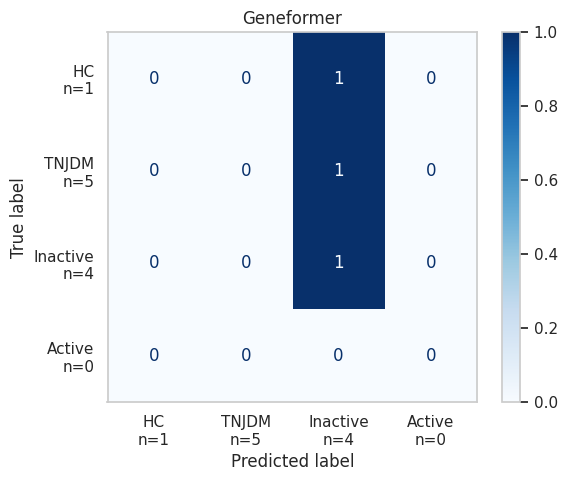

In [11]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory="quick_test_results",
        output_prefix="quick_eval",
)